# How to handle output data

This tutorial explains the structure of the `Data` classes, then shows how to extract slices, convert units, compare fields, or customize Fourier Transform parameters.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_DataObject.ipynb).

## Data class structure
The `Data` class is composed of:
- classes describing axes (`Data1D` and `DataLinspace`)
- classes describing fields stored in the time/space domain (`DataTime`) or in the frequential domain (`DataFreq`).

The following UML summarizes this structure:

<div>
<img src="_static/UML_Data_Object.png" width="450"/>
</div>

## How to create a Data object
At the end of a simulation, the idea is to store the resulting fields into `Data` objects before post-processing them. To do so, the axes have to be created first.

### How to create a Data1D object
A `Data1D` object has four properties: a `name`, a `unit`, a dictionary for `symmetries`, and a numpy array for the `values`.

- The `name` is a string and can be user-defined, although restrictions appear when one wants to perform Fourier transforms. In this case, the correspondance with the frequency domain names must exist among the predefined correspondances:
  + `"time"` &harr; `"freqs"`
  + `"angle"` &harr; `"wavenumber"`
  
<font color='red'>To be expanded + possibility to manually enter relation?</font>

- The `unit` is also a string, and corresponds to the symbol of the unit (*dimless, m, rad, °, g, s, min, h, Hz, rpm, degC, A, J, W, N, C, T, G, V, F, H, Ohm, At, Wb, Mx*), with a prefix (*k*, *h*, *da*, *d*, *c*, *m*, etc.). Composed units are also available (e.g. `"mm/s^2"`). It is used for labelling plot axes, so that it is best to use a LaTeX formatting.


- The `symmetries` are used to reduce storage: a signal can be periodic ($f(t+T)=f(t)$) or antiperiodic ($f(t+T)=-f(t)$). The symmetries dictionary must be filled with the name of the axis and a dictionary of its symmetry (`{"period": n}` or `{"antiperiod": n}`, with *n* the number of periods in the complete signal. Note that the symmetries dictionary must be shared with the field itself (`DataTime` or `DataFreq`).


In the following example, the time vector is imported from an xls file and stored in a `Data1D` object. A second object is created using a 1/3 periodicity to demonstrate the use of the symmetries dictionary:

In [1]:
# Add pyleecan to the Python path
import sys
sys.path.append('../..')

from os.path import join
from numpy import squeeze

from pyleecan.Classes.Data1D import Data1D
from pyleecan.Classes.ImportMatrixXls import ImportMatrixXls
from pyleecan.Tests import DATA_DIR

xls_file_time = join(DATA_DIR, "default_proj_time.xlsx")
time = squeeze(ImportMatrixXls(file_path=xls_file_time, sheet="default_proj_time").get_data())
time_reduced = time[0:672]

Time = Data1D(name="time", unit="s", symmetries={}, values=time)

Time_reduced = Data1D(name="time", unit="s", symmetries={"time": {"period": 3}}, values=time_reduced)

### How to create a DataLinspace object
Axes often have a regular distribution, so that the use of `DataLinspace` allows to reduce the storage.

A `DataLinspace` object has five properties instead of the `values` array: `initial`, `final`, `step` and `number` allow to define the linspace vector (3 out of these 4 suffice), and `include_endpoint` is a boolean used to indicate whether the final point should be included or not.

In the following example, an angle vector is defined as a linspace:


In [2]:
from numpy import pi
from pyleecan.Classes.DataLinspace import DataLinspace

Angle = DataLinspace(
            name="angle",
            unit="rad",
            symmetries={},
            initial=0,
            final=2*pi,
            number=2016,
            include_endpoint=False,
        )

### How to create a DataTime object
Once the axes have been created, the objects for the fields can be created. If the field is defined in the time/space domain, the `DataTime` class has to be used.

5 additional properties must be defined (note that `name` will be used in the titles of the plots, and `symmetries` should correspond to the axes symmetries):
- `symbol` is the LaTeX formatted string which will be used as a label in the plots
- `axes` is a list of `Data1D` or `DataLinspace` objects corresponding to the axes used in the field
- `normalizations` is a dictionary prescribing the values to be used to normalize the field (through the use of a `is_norm` flag which we will see later) or one of its axes: use `{"unit": X0}` for a field normalization (e.g. `normalizations={"T": 0.8}`), or the name of the normalized axis (e.g. `normalizations={"elec_order": 60}`)
- `FT_parameters` is a dictionary of the type of Fourier Transform to use (`type`, `window`, `window_width`, etc.)
- `values` is a numpy array

See below two examples of `DataTime`creation, without and with symmetry:

In [3]:
from pyleecan.Classes.DataTime import DataTime

xls_file_Br = join(DATA_DIR, "default_proj_Br_time_angle.xlsx")
field = ImportMatrixXls(file_path=xls_file_Br, sheet="default_proj_Br_time_angle").get_data()
field_reduced = field[0:672, :]

Br = DataTime(
            name="Airgap radial flux density",
            unit="T",
            symmetries={},
            symbol="B_r",
            axes=[Time, Angle],
            normalizations={"elec_order": 60, "space_order": 3},
            values=field,
        )

Br_reduced = DataTime(
            name="Airgap radial flux density",
            unit="T",
            symmetries={"time": {"period": 3}},
            symbol="B_r",
            axes=[Time, Angle],
            normalizations={"elec_order": 60, "space_order": 3},
            values=field_reduced,
        )

### How to create a DataFreq object
If one prefers to store data in the frequency domain, for example because most postprocessings will handle spectra, the `DataFreq` class can be used.

The definition is similar to the `DataTime` one: the axes now have to be frequencies or wavenumbers (see following example, with an import from Matlab files).

In [4]:
from pyleecan.Classes.DataFreq import DataFreq
from pyleecan.Classes.ImportMatlab import ImportMatlab

mat_file_Br_cfft2 = join(DATA_DIR, "default_proj_Br_cfft2.mat")
mat_file_Brfreqs = join(DATA_DIR, "default_proj_Brfreqs.mat")
mat_file_Brwavenumber = join(DATA_DIR, "default_proj_Brwavenumber.mat")

Br_cfft2 = squeeze(ImportMatlab(file_path=mat_file_Br_cfft2, var_name="Fwr").get_data())
freqs_Br = squeeze(ImportMatlab(file_path=mat_file_Brfreqs, var_name="freqs").get_data())
wavenumber = squeeze(ImportMatlab(file_path=mat_file_Brwavenumber, var_name="orders").get_data())

Freqs = Data1D(name="freqs", unit="Hz", symmetries={}, values=freqs_Br,)

Wavenumber = Data1D(name="wavenumber", unit="", symmetries={}, values=wavenumber)

Br_fft = DataFreq(
            name="Airgap radial flux density",
            unit="T",
            symmetries={},
            symbol="B_r",
            axes=[Freqs, Wavenumber],
            normalizations={},
            values=Br_cfft2,
        )

## How to extract slices in the time/space domain

The `DataTime` and `DataFreq` classes have built-in methods to extract slices of the field: the `get_along` methods. These methods allow to extract *nD* slices, into a requested unit (provided that it is compatible with the unit used in the definition of the field, or is defined in the normalizations dictionary), possibly normalized, and taking symmetries into account.

Here is a synopsis of the methods:
- Read the axes requested, their range and their units. The possible syntaxes are the following:
  + `"angle"` for the field over the complete axis
  + `"angle=0"` for a slice of the field at a single value (possibly interpolated and first occurence if repeated)
  + `"angle[0]"` for a slice of the field at a single index. `[-1]` can be used to access the last value.
  + `"angle=[0,3*pi/2]"` for the field over an interval of values (possibly interpolated and first occurence if repeated)
  + `"angle[0:200]"` for the field over an interval given by indices
  + `"angle=axis_data"` for the field over an input vector (using interpolation). This input vector has then to be specified as the argument: `axis_data=[axis_data1, ...]` in the `get_along` method.

The unit of the axis can be added to any of the previous strings as `{unit}` (e.g. `"angle[-1]{°}"`).

If nothing is specified regarding an axis from the `axes` list, a slice at its first value will be extracted.

- Extract the requested axes by calling the `get_axis` methods. These methods will first rebuild the complete axis if a symmetry was used, or compute the time/space axes if the field was stored in the frequency domain, then convert to the requested unit or normalization. If necessary, the axis is then interpolated on the prescribed values (interval or `axis_data`).


- The whole field is then reconstructed using the symmetries if the corresponding axis is requested.


- The slices of the field are extracted (single index or interval of indices).


- The inverse Fourier Transform is performed if necessary (`DataFreq`).


- The field is interpolated over the specified axis values.


- The field values are converted to the requested unit. Note that conversions to dB and dBA are available, provided that the normalization value was specified in the `normalization` dictionary.


The `get_along` methods return a tuple containing the axes and the field arrays.

The following examples show different usage of the `get_along` methods. Note that plot methods are available within the `Output` class (see [How to plot data fields](./tuto_plots.ipynb)).

<IPython.core.display.Javascript object>


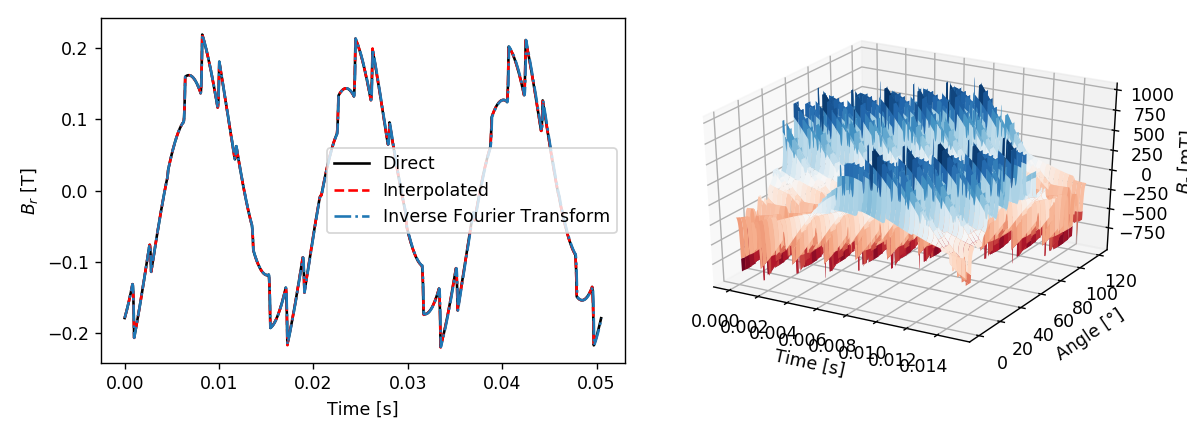

Text(0.5, 0, '$B_r$ [mT]')

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
from numpy import linspace, meshgrid

time_data = linspace(0, 0.05, 1000)

(Xdata1, Ydata1) = Br.get_along("time")
(Xdata2, Ydata2) = Br.get_along("time=axis_data", axis_data=[time_data])
(Xdata3, Ydata3) = Br_fft.get_along("time")

(Xdata4, Ydata4, Zdata4) = Br.get_along("time=[0,0.015]", "angle[0:672]{°}", unit="mT")
Ydata_map, Xdata_map  = meshgrid(Ydata4, Xdata4)

fig = plt.figure(tight_layout=True, figsize=(9.5, 3.5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(Xdata1, Ydata1, 'k', Xdata2, Ydata2, '--r', Xdata3, Ydata3, '-.')
ax.legend(["Direct", "Interpolated", "Inverse Fourier Transform"])
plt.xlabel("Time [s]")
plt.ylabel(r"$"+Br.symbol+"$ ["+Br.unit+"]")
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(Xdata_map, Ydata_map, Zdata4, cmap="RdBu")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Angle [°]")
ax.set_zlabel(r"$"+Br.symbol+"$ [mT]")

## How to extract slices in the frequential domain

To extract slices in the frequential domain, i.e. to extract complex Fourier Transform, magnitude or phase, use the methods: `get_FT_along`, `get_magnitude_along` or `get_phase_along`. The principle is the same as in the `get_along` methods, with the addition of the Fourier Transform. The default method for the Fourier Transform is the numpy fft. See [6. How to customize Fourier Transform parameters](#section6) for other Fourier Transform methods.

The frequencies can be converted to orders (electrical orders, space orders, mechanical orders, etc.) using the `normalizations` dictionary (see example below).

<IPython.core.display.Javascript object>


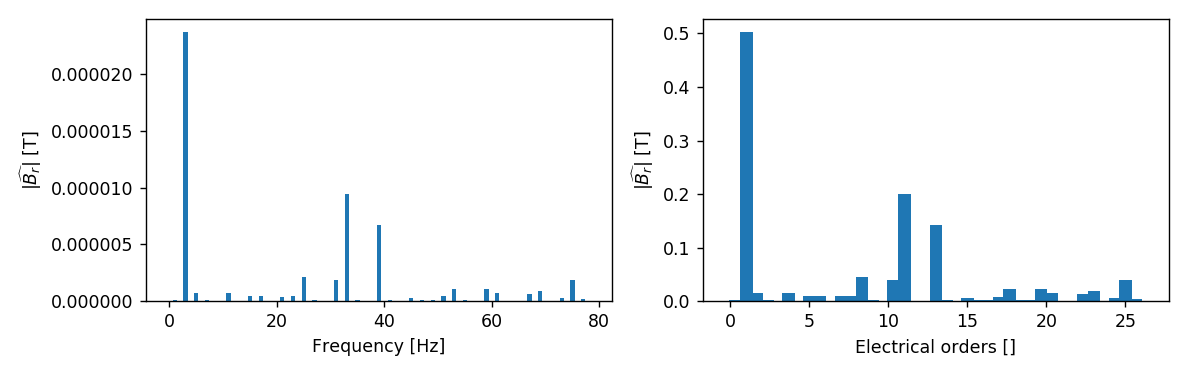

Text(0, 0.5, '$|\\widehat{B_r}|$ [T]')

In [6]:
(Xdata5, Ydata5) = Br_fft.get_magnitude_along("wavenumber=[0,78]")
(Xdata6, Ydata6) = Br.get_magnitude_along("wavenumber=[0,26]{space_order}")

fig = plt.figure(tight_layout=True, figsize=(9.5, 3))
ax = fig.add_subplot(1, 2, 1)
ax.bar(Xdata5, Ydata5)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$|\widehat{"+Br.symbol+"}|$ ["+Br.unit+"]")
ax = fig.add_subplot(1, 2, 2)
ax.bar(Xdata6, Ydata6)
plt.xlabel("Electrical orders []")
plt.ylabel(r"$|\widehat{"+Br.symbol+"}|$ ["+Br.unit+"]")

## How to compare several fields

The `Data` classes allow to easily compare several fields in the same graph, even if they don't have the same basis or are stored in different time/frequency domains. To do so, the `compare_along` method find a common basis for the axes requested, and interpolate the fields on this common basis. Restrictions for the axes can be similarly input through strings, as well as unit and normalization, and the other fields to compare must be input in the `data_list` argument.

Note that if `data_list` is not specified, the `get_along` method will simply be called, so that this method can be used by default (which is the case in the [plot methods](./tuto_plots.ipynb))). Note also that `compare_FT_along`, `compare_magnitude_along` and `compare_phase_along` are available for comparisons of spectra.

<IPython.core.display.Javascript object>


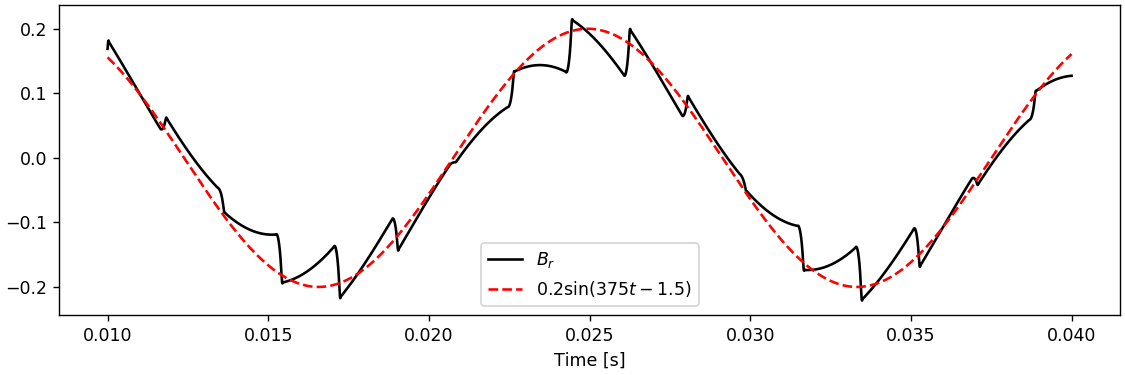

Text(0.5, 0, 'Time [s]')

In [7]:
from numpy import sin

t0 = 0.01
tf = 0.04
Nt = 3000
time2 = linspace(0.01, 0.04, 3000, endpoint=True)
sine_function = 0.2 * sin(375 * time2 - 1.5)

# Build the data objects
Time = DataLinspace(
            name="time",
            unit="s",
            symmetries={},
            initial=t0,
            final=tf,
            number=Nt,
            include_endpoint=True,
        )
Sine = DataTime(
            symbol="0.2\sin(375t-1.5)",
            name="Sine function",
            unit="T",
            symmetries={},
            axes=[Time],
            normalizations={},
            values=sine_function,
        )

(Xdata7, Ydata7) = Br.compare_along("time", data_list=[Sine])

fig = plt.figure(constrained_layout=True, figsize=(9, 3))
plt.plot(Xdata7, Ydata7[0], 'k', label=r"$"+Br.symbol+"$")
plt.plot(Xdata7, Ydata7[1], '--r', label=r"$"+Sine.symbol+"$")
plt.legend()
plt.xlabel("Time [s]")

## How to customize Fourier Transform parameters
<font color='red'>To be developed -> illustrations of fft capacities</font>